<a href="https://colab.research.google.com/github/busayojee/deeplearning/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt




Data Engineering

In [ ]:
data = "/content/drive/MyDrive/creditcard.csv"
def split():
  dt = pd.read_csv(data, header=0)
  print(dt.head())
  dt.drop('Time', axis=1, inplace=True)
  print(dt.head())
  print(dt.iloc(1))
  # print(dt.info())
  # # print(dt.isna().sum(axis=0))
  # # print(dt.isna().sum(axis=1))
  # # print(dt.isnull().sum())
  # dt = dt.sample(frac=1)
  print(dt.shape)

  # splitting into train test val
  train, test = train_test_split(dt, test_size=0.3)
  train.to_csv("train.csv")
  test.to_csv("test.csv")
  print(train.shape)
  print(test.shape)

split()

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Loading the data into a dictionary


In [ ]:
def load_data():
  train = pd.read_csv("train.csv")
  test = pd.read_csv("test.csv")
  train = train.drop("Unnamed: 0", axis=1)
  test = test.drop("Unnamed: 0", axis=1)
  
  print(train.Class.value_counts())
  print(test.Class.value_counts())

  data = {}
  data["train_y"] = train.pop("Class")
  data["test_y"] = test.pop("Class")

  scaler = StandardScaler()
  train = scaler.fit_transform(train)
  test = scaler.transform(test)

  data["train_x"] = train
  data["test_x"] = test
  data["scaler"] = scaler
  print(data["scaler"])
  return data

data = load_data()
# print(data["scaler"])
# print(data["train_y"].shape)
# print(data["train_x"].shape)
# print(data["train_y"])




0    199018
1       346
Name: Class, dtype: int64
0    85297
1      146
Name: Class, dtype: int64
StandardScaler()


Building the Model

In [ ]:
from tensorflow.python import metrics
def model(input_features):
  # fraud7 with metrics Recall at precision
  input = tf.keras.layers.Input(shape=(input_features,))
  x = tf.keras.layers.Dense(128, activation='relu', 
                            kernel_initializer='he_uniform', 
                            use_bias=True, 
                            kernel_regularizer = tf.keras.regularizers.l2(0.01))(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_initializer='he_uniform', 
                            use_bias=True,  
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs =input, outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss = "binary_crossentropy", metrics = ["accuracy"])
  return model

m = model(29)

print(m.summary())




  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 128)               3840      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

Training the model

In [ ]:
# Creating callback
def checkpoint():
  tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs1', 
                                               write_graph = True, write_grads = False)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.2, patience=4, min_lr=0.0001)
  return [tensorboard, early_stopping, reduce_lr]

In [ ]:
# training the data
data = load_data()
input = data["train_x"].shape[1]
print(input)
models = model(input_features = input)
callbacks = checkpoint()
models.fit(x = data["train_x"], y = data["train_y"], batch_size = 64, 
           epochs=30, verbose=1, validation_split = 0.2, callbacks = callbacks)
models.save("fraud4.h5")



0    199042
1       322
Name: Class, dtype: int64
0    85273
1      170
Name: Class, dtype: int64
StandardScaler()
29
Epoch 1/30
2493/2493 [==============================] - 14s 5ms/step - loss: 0.4762 - accuracy: 0.9757 - val_loss: 0.0408 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 2/30
2493/2493 [==============================] - 11s 5ms/step - loss: 0.0258 - accuracy: 0.9988 - val_loss: 0.0261 - val_accuracy: 0.9993 - lr: 0.0010
Epoch 3/30
2493/2493 [==============================] - 12s 5ms/step - loss: 0.0164 - accuracy: 0.9988 - val_loss: 0.0243 - val_accuracy: 0.9993 - lr: 0.0010
Epoch 4/30
2493/2493 [==============================] - 12s 5ms/step - loss: 0.0142 - accuracy: 0.9989 - val_loss: 0.0167 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 5/30
2493/2493 [==============================] - 12s 5ms/step - loss: 0.0120 - accuracy: 0.9989 - val_loss: 0.0142 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 6/30
2493/2493 [==============================] - 12s 5ms/step - loss: 0.0107 - accura

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs1

In [ ]:
model = tf.keras.models.load_model("fraud4.h5")
prediction = model.predict(data["test_x"])

2671/2671 [==============================] - 5s 2ms/step


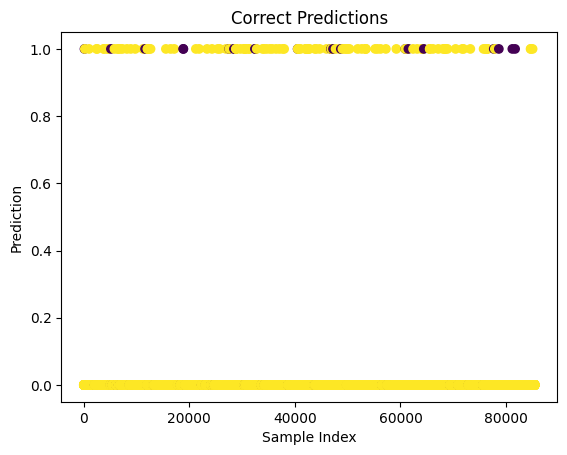

In [ ]:
df_ans = pd.DataFrame({'Real Class' :data["test_y"]})
df_ans['Prediction'] = prediction >0.5
df_ans[ df_ans['Real Class'] != df_ans['Prediction'] ]
# Convert predictions to binary labels (0 or 1)
predictions = prediction > 0.5

predictions = predictions.reshape(-1)
# Plot a graph to show the correct predictions
y_test = data["test_y"]
# Plot a graph to show the correct predictions
plt.scatter(range(len(predictions)), predictions, c=predictions == y_test)
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.title('Correct Predictions')
plt.show()

In [ ]:
df_ans['Prediction'].value_counts()

False    85304
True       139
Name: Prediction, dtype: int64

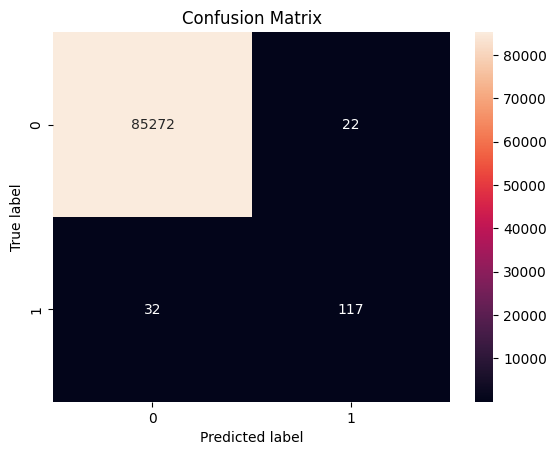

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
# fraud 7

Testing with single input instances from the test data

In [ ]:
test = pd.read_csv("test.csv")
test = test.drop("Unnamed: 0", axis=1)

test = test.iloc[196]
test_y = test.pop("Class")
input = test.values
print(input)
print(test_y)


[-1.58550537  3.26158455 -4.13742198  2.35709625 -1.40504331 -1.87943719
 -3.51368687  1.51560675 -1.20716636 -6.23456133  5.45074607 -7.33371407
  1.36119332 -6.60806825 -0.48106942 -2.60247787 -4.83511205 -0.55302609
  0.35194894  0.31595726  0.50154315 -0.54686881 -0.07658364 -0.42555037
  0.12364419  0.32198454  0.26402816  0.13281672  1.        ]
1.0


In [ ]:

scaler = data["scaler"]
print(test_y)
input = input.reshape(1,-1)
scaled = scaler.transform(input)
print(scaled.shape)

prediction = model.predict(scaled)
# print(predictions)
print(prediction)
if test_y == (prediction > 0.5):
    print("The prediction is correct.")
else:
    print("The prediction is incorrect.")

1.0
(1, 29)
1/1 [==============================] - 0s 22ms/step
[[0.99998444]]
The prediction is correct.


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
xtest = data["test_x"]
ytest = data["test_y"]
scaler = data["scaler"]
# for i in range(len(ytest)):
#   if ytest[i] == 1:
#     print(i)
    

xtest_inst = xtest[196:197]
ytest_int = ytest[196:197]
predictions = model.predict(xtest_inst)
print(ytest_int.values[0])
print(int(predictions))



1/1 [==============================] - 0s 22ms/step
1
0


Hyperparameter Tuning Using random search (Run only once because of the time it takes)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# # specify the hyperparameters and the possible values
# def create_model(optimizer='adam'):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='uniform', 
#                 kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(64, activation='relu', 
#               kernel_initializer='uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#     model.compile(optimizer=optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
#     return model

# param_grid = {'epochs': [10, 20, 30], 'batch_size': [32, 64, 128], 
#               'optimizer': ['Adam','RMSprop']}
# estimator = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model)
# grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter=10,
#  cv=3, n_jobs=-1)
# grid.fit(data["train_x"], data["train_y"])

In [ ]:
best_params = grid.best_params_
print(best_params)

{'optimizer': 'Adam', 'epochs': 30, 'batch_size': 64}


Deploying the model using FLASK API

In [ ]:
!pip install --upgrade flask-ngrok
!pip install pyngrok
!ngrok authtoken 1k9L5QgWAlcGov4IeWwaJBsc6gK_7RDCMELZb76jKjMw6y17o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19879 sha256=e47904e2d75398860a2d2b0c7ea9a1dd16a5739dcdc7e6df1d35d2c3f5d260f2
  Stored in directory: /root/.cache/pip/wheels/31/49/9c/44b13823eb256a3b4dff34b972f7a3c7d9910bfef269e59bd7
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask import Flask, render_template, request, redirect
from werkzeug.utils import secure_filename
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok
import os

In [ ]:
!ngrok http 5000 --host-header rewrite

In [ ]:
 # Create static and upload folder before running this code
app = Flask(__name__)
run_with_ngrok(app)
# load your model
model = tf.keras.models.load_model("fraud4.h5")
scaler = data["scaler"]
file_name = []
EXT = ['csv']
UPLOADS = "static/upload"
app.config["UPLOADS"] = UPLOADS
# check if filename is correct
def files(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in EXT
@app.route('/', methods=['POST','GET'])
def form():
    if request.method == "POST":
      f = request.files["file"]
      if f.filename != "":
        if files(f.filename):
          filename = secure_filename(f.filename)
          f.save(os.path.join(app.config['UPLOADS'], filename))
          file_name.append(os.path.join(app.config['UPLOADS'], filename))
          print(file_name)
          return redirect('/predict')
        else:
          return str("Not correct filetype")  
    return render_template('form.html')

@app.route('/predict', methods=['GET'])
def predict():
    data = file_name[0]
    # print(data)
    # get the input values from the file
    dat = pd.read_csv(data, index_col=1)
    
    # convert the input values to a numpy array
    input_values = np.array(dat).reshape(1, -1)
    print(input_values)
    input_values = scaler.transform(input_values)
    # make a prediction
    prediction = model.predict(input_values)
    file_name.pop(0)
    # return the prediction
    if prediction[0][0] == 1:
      return f"{prediction[0][0]}: Your account has undergone fraudulent transactions. Please contact your bank account manager to take the next steps. Thank you."
    else:
      return f"{prediction[0][0]}: Your account is fraud free. "

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://181b-34-170-101-31.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/Apr/2023 21:05:24] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Apr/2023 21:05:25] "GET /favicon.ico HTTP/1.1" 404 -
